In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.utils import compute_sample_weight
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import RobustScaler

from sklearn.cluster import KMeans

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

import optuna

import mlflow

import warnings

warnings.simplefilter('ignore')

import joblib

from joblib import dump, load

import requests

client = mlflow.MlflowClient(tracking_uri="http://127.0.0.1:8082")

mlflow.set_tracking_uri("http://127.0.0.1:8082")

import requests

from sklearn import impute

from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline



In [5]:

data = pd.read_csv("train.csv")

In [6]:

y = data['income_>50K']

In [7]:
X = data.drop(['income_>50K'], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

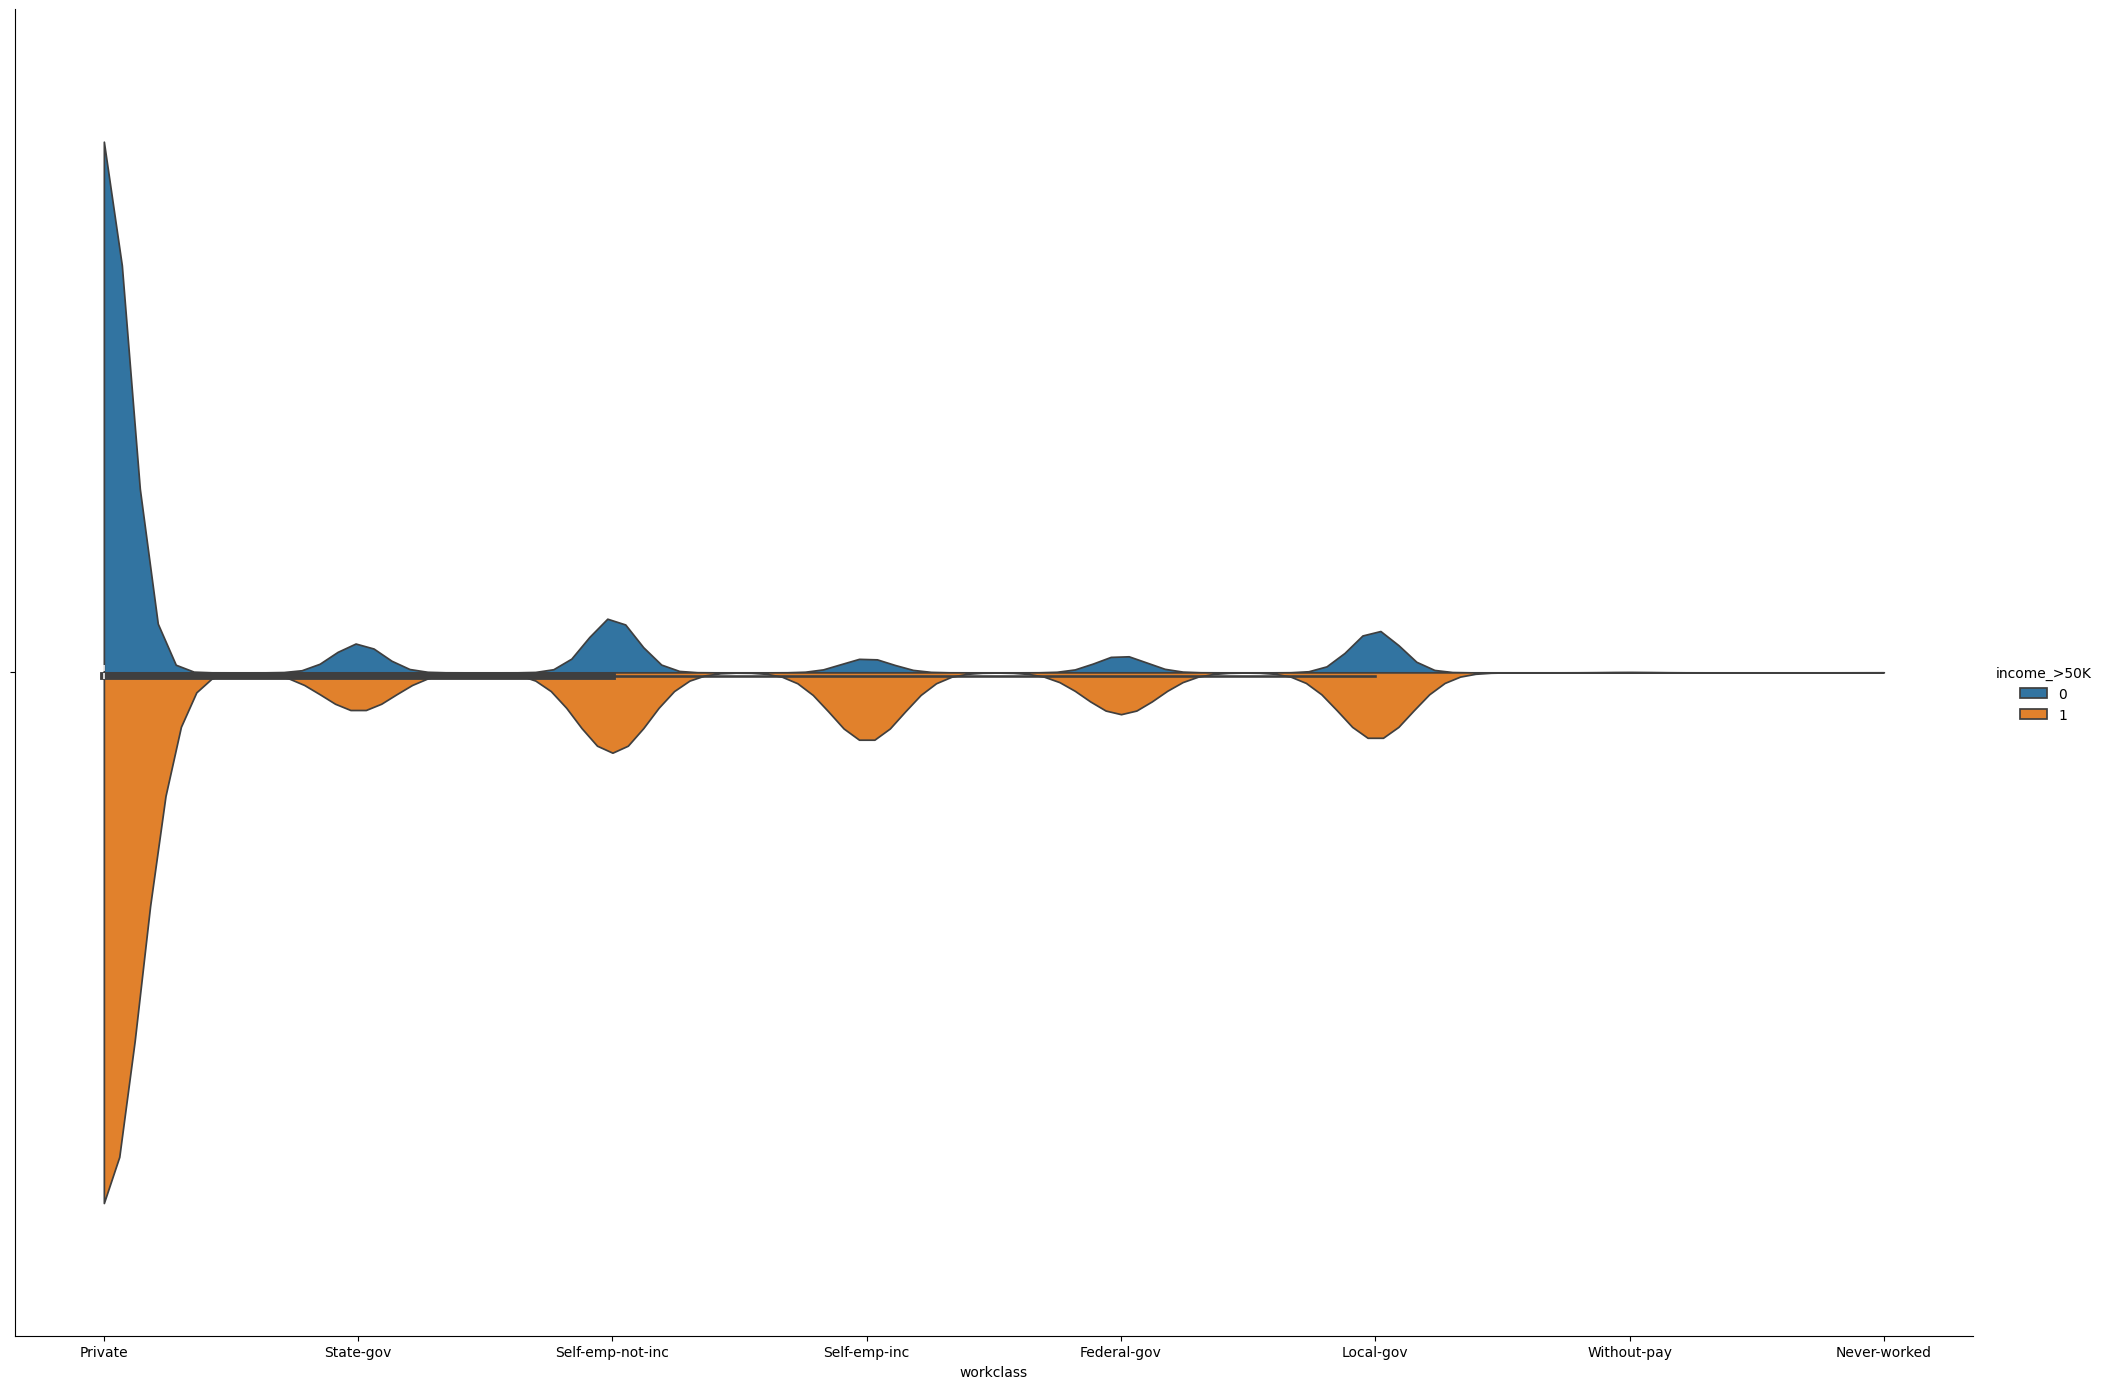

In [9]:
# 
df_for_sns = pd.concat([X_train,pd.DataFrame(y_train)], axis=1)
sns.catplot(
    data=df_for_sns, hue="income_>50K", x="workclass",
    kind="violin", bw_adjust=.5, cut=0, split=True, height=14, aspect=20/16
)

In [10]:
num_columns = list(X_train.select_dtypes(exclude=['object']).columns)
num_columns

['age',
 'fnlwgt',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [11]:
cat_columns = list(X_train.select_dtypes(include=['object']).columns)

In [12]:

desired_minority_ratio = 20 / 50
#desired_minority_ratio = 40 / 60 

numerical = Pipeline(steps=[
    ("simple_imputer", SimpleImputer()),
    #("Imputer", KNNImputer()),
    #("SMOTE", SMOTE(sampling_strategy=desired_minority_ratio)),
    ('Scaler', StandardScaler())
])

categorical = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy='constant')),
    ("OneHotEncoder", OneHotEncoder(handle_unknown='ignore', #drop=['first', 'if_binary'],
                                    sparse_output=False))
])

ct = ColumnTransformer([
    ("numerical", numerical, num_columns),
    ("categorical", categorical, cat_columns)
], remainder = 'passthrough')


pipe = Pipeline(steps=[
    ("ct", ct),
    ("SMOTE", SMOTE(sampling_strategy=desired_minority_ratio)),
    ("Imputer", KNNImputer()),
    ("XGBClassifier", XGBClassifier())
])

In [13]:
counter = 0

In [10]:
list_of_imputers = ['simple_imputer', 'KNNImputer', 'IterativeImputer']
list_of_imputers.index('KNNImputer')
list_of_imputers_object = [SimpleImputer(), KNNImputer(), IterativeImputer()]
list_of_imputers_object[list_of_imputers.index('KNNImputer')]

KNNImputer()

In [14]:

counter += 1
def gridsearch_replacment(trial):
    list_of_imputers = ['simple_imputer', 'KNNImputer', 'IterativeImputer']
    list_of_imputer_object = [SimpleImputer(), KNNImputer(), IterativeImputer()]
    imputer_name = trial.suggest_categorical('Imputer', list_of_imputers)
    pipe.set_params(**{'Imputer': list_of_imputer_object[list_of_imputers.index(imputer_name)]})
    
    #
    params = {
        'XGBClassifier__n_estimators': trial.suggest_int('XGBClassifier__n_estimators', 1, 100) ,
        'XGBClassifier__learning_rate': trial.suggest_float('XGBClassifier__learning_rate', 0.01, 0.1),
        'XGBClassifier__max_depth': trial.suggest_int('XGBClassifier__max_depth', 5, 15),
        'XGBClassifier__gamma': trial.suggest_int('XGBClassifier__gamma', 1, 6),
        
    }
    
    pipe.set_params(**params)
    #score = cross_val_score(pipe, X_train, y_train, cv=5, scoring = make_scorer(f1_score, average='macro')).mean()
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring = 'f1_macro').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(gridsearch_replacment, n_trials=5)


[I 2024-02-01 21:53:48,845] A new study created in memory with name: no-name-2887afc0-989c-4576-b9a6-bb3e37eadc9f
[W 2024-02-01 21:54:32,360] Trial 0 failed with parameters: {'Imputer': 'IterativeImputer', 'XGBClassifier__n_estimators': 46, 'XGBClassifier__learning_rate': 0.09111300992925263, 'XGBClassifier__max_depth': 12, 'XGBClassifier__gamma': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Timur\anaconda3\envs\smote\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Timur\AppData\Local\Temp\ipykernel_26444\1978580194.py", line 20, in gridsearch_replacment
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring = 'f1_macro').mean()
  File "C:\Users\Timur\anaconda3\envs\smote\lib\site-packages\sklearn\model_selection\_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
  File "C:\Users\Timur\anaconda3\envs\smote\lib\sit

KeyboardInterrupt: 

In [12]:
#Now lets create an MLFlow experiment
with mlflow.start_run(run_name=f'{counter}_experiment'): 
    st_b = study.best_params
    mlflow.log_params(st_b)
    stud_bv = study.best_value
    #mlflow.log_metric('f1_macro_cv5', stud_bv)

    pipe.set_params(**st_b)
    pipe.fit(X_train, y_train)
    mlflow.sklearn.log_model(pipe,'best_model_metrics')

    pred_test = pipe.predict(X_test)
    f1_test = f1_score(pred_test, y_test, average='macro')
    #mlflow.log_metric('f1_score_macro', f1_test)

    log_sum = {'f1_macro_cv5': stud_bv,
               'f1_score_macro': f1_test}

    mlflow.log_metrics(log_sum)

In [ ]:
study.best_value

In [13]:

erorr_xtest= f1_score(pred_test, y_test)
erorr_xtest

0.7123058941392553

In [14]:
# Loaded model from mlflow
logged_model = 'runs:/97ad0bf2f6584b3c866570a724b61287/best_model_metrics'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

array([1, 0, 1, ..., 0, 0, 0])

In [15]:
mlflow.set_experiment('first_experiment')

<Experiment: artifact_location='mlflow-artifacts:/695775722535131468', creation_time=1706290723275, experiment_id='695775722535131468', last_update_time=1706290723275, lifecycle_stage='active', name='first_experiment', tags={}>

In [16]:
# added pipeline to MLFlow
pipe.fit_resample(X_train, y_train)

In [17]:
X_train

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
15326,27,Local-gov,134813,Masters,14,Never-married,Prof-specialty,Own-child,White,Male,0,0,52,United-States
11010,30,Private,55481,Masters,14,Never-married,Tech-support,Unmarried,White,Male,0,0,45,Nicaragua
16940,35,Private,98389,11th,7,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States
19653,45,Private,175925,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States
20900,52,Self-emp-not-inc,182796,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39126,32,Private,256362,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
34452,43,Private,109762,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,20,United-States
14609,60,Private,349898,HS-grad,9,Widowed,Other-service,Not-in-family,White,Female,0,0,44,United-States
27910,70,Private,170428,Bachelors,13,Widowed,Prof-specialty,Unmarried,White,Female,0,0,20,Puerto-Rico


In [18]:
# For KNNImpute
pipe.fit_transform(X_train, y_train)

AttributeError: 'XGBClassifier' object has no attribute 'transform'

In [ ]:
# violin 
df_for_sns = pd.concat([X_train,pd.DataFrame(y_train)], axis=1)
sns.catplot(
    data=df_for_sns, hue="income_>50K", x="workclass",
    kind="violin", bw_adjust=.5, cut=0, split=True, height=14, aspect=20/14
)

In [ ]:
#Create a function to inverse the OneHotEncoder
def inverse_ohe(ohe, df):
    inverse_df = ohe.inverse_transform(df)
    inverse_df = pd.DataFrame(inverse_df, columns=ohe.get_feature_names(df.columns))
    return inverse_df